In [1]:
import itertools
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Data

In [2]:
static_path = 'input/glass/frames/0000.png'
img_path = 'input/glass/frames/0001.png'

static = cv2.imread(static_path)
img = cv2.imread(img_path)

static = cv2.cvtColor(static, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

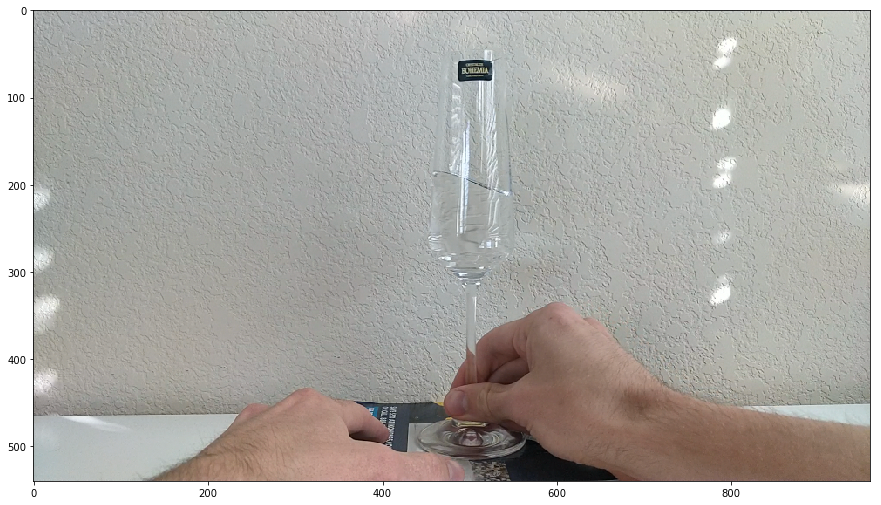

In [3]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.imshow(static)

In [4]:
img.shape

(540, 960, 3)

# Find features

In [5]:
def draw_pts(img, pts):
    new_img = img.copy()
    for pt in pts:
        cv2.circle(new_img, (pt[0][0], pt[0][1]), 1, (0, 255, 0), -1)
    return new_img

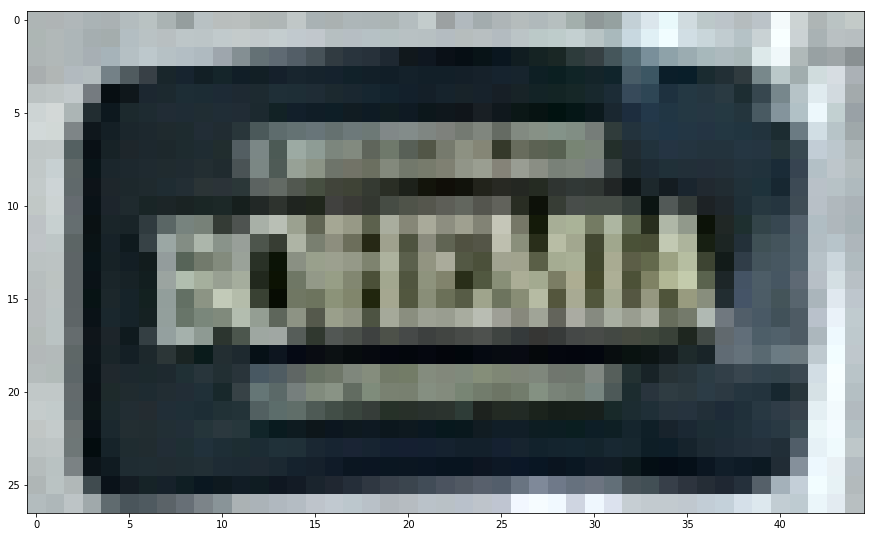

In [6]:
# bb = [400, 430, 520, 550]
bb = [55, 485, 82, 530]
plt.imshow(static[bb[0]: bb[2], bb[1]: bb[3]])

In [7]:
feature_params = dict( maxCorners = 100, 
                       qualityLevel = 0.1,
                       minDistance = 3,
                       blockSize = 3)

(25, 1, 2)

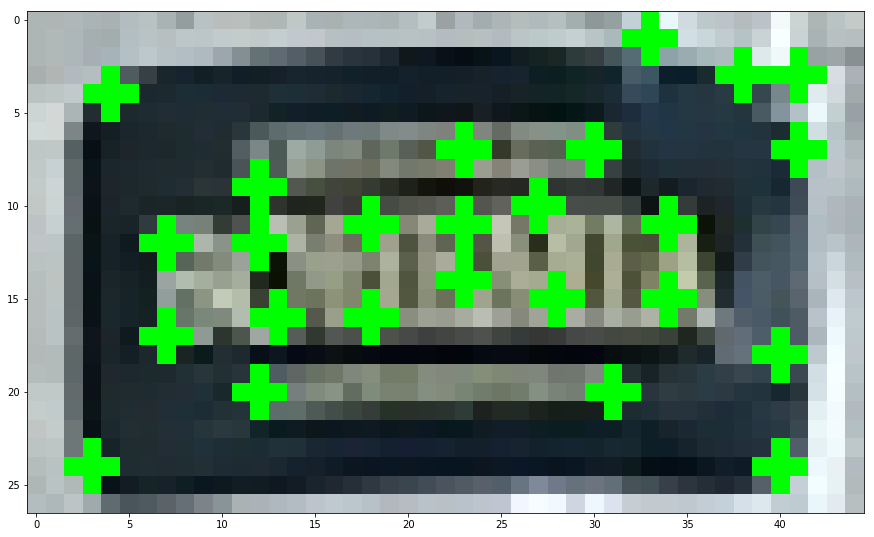

In [8]:
img1 = static[bb[0]:bb[2],bb[1]:bb[3]] # crop the bounding box area
g = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY) # get grayscale image
static_pts = cv2.goodFeaturesToTrack(g, **feature_params)

plt.imshow(draw_pts(img1, static_pts))
# pt is for cropped image. add x, y in each point.
for i in xrange(len(static_pts)):
    static_pts[i][0][0] += bb[1]
    static_pts[i][0][1] += bb[0]
static_pts.shape

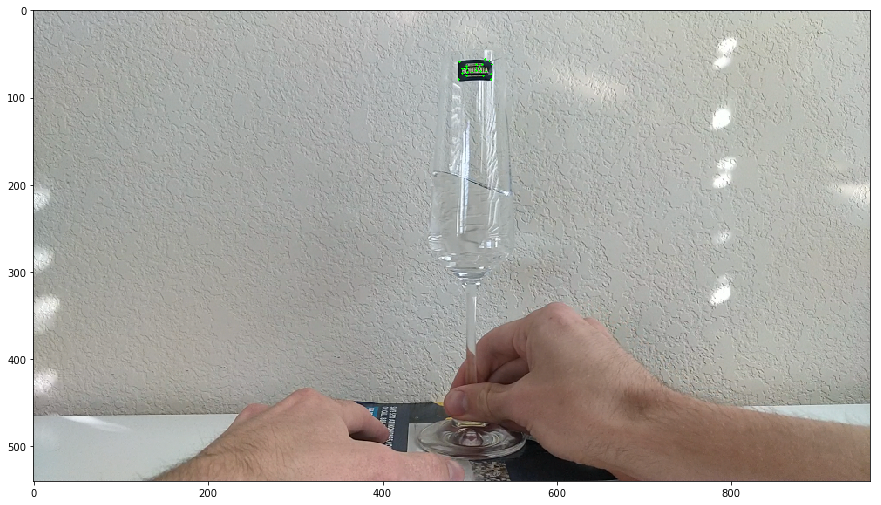

In [9]:
plt.imshow(draw_pts(static, static_pts))

# Tracking

In [10]:
lk_params = dict( winSize  = (10, 10), 
                  maxLevel = 5, 
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))   

In [11]:
def track(img1, img2, p0):
    oldg = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    newg = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    
    # For Forward-Backward Error method
    # using calcOpticalFlowPyrLK on both image frames
    # with corresponding tracking points

    p1, st, err = cv2.calcOpticalFlowPyrLK(oldg, newg, p0, 
                                           None, **lk_params)
    p0r, st, err = cv2.calcOpticalFlowPyrLK(newg, oldg, p1, 
                                           None, **lk_params)
    d = abs(p0-p0r).reshape(-1, 2).max(-1)
    good = d < 1
    
    return p1, good

# Warping

In [12]:
def warp(pts1, pts2, img):
    dsize = img.shape[1], img.shape[0]
    dx = (pts2[:5] - pts1[:5])[:,0,0].mean()
    dy = (pts2[:5] - pts1[:5])[:,0,1].mean()
    M = np.array([[1,0,dx],
                  [0,1,dy]])
    
    #pts1 = p0[:3,0,:]
    #pts2 = static_pts[:3,0,:]
    #M = cv2.getAffineTransform(pts1,pts2)

    warped_img = cv2.warpAffine(img,M,dsize)
    
    return warped_img

# Blending

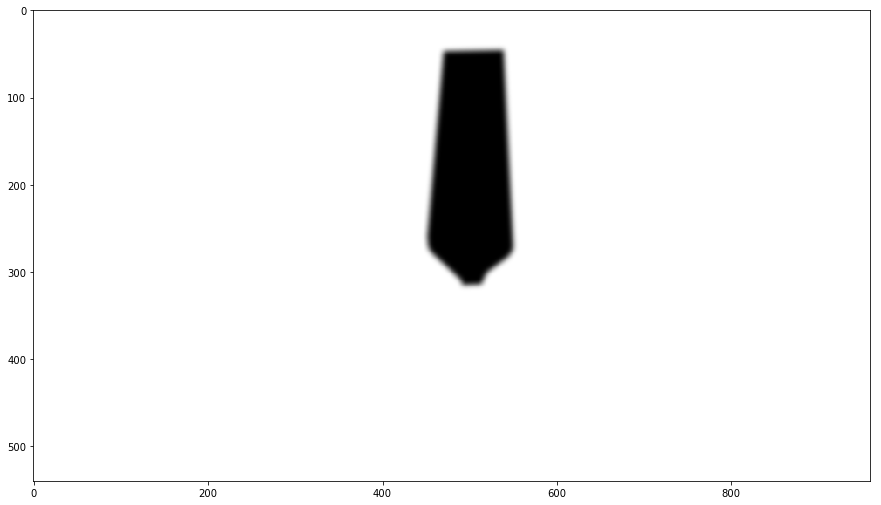

In [13]:
mask_path = 'input/glass/dyn_mask.png'

dyn_mask = cv2.imread(mask_path)
dyn_mask = cv2.cvtColor(dyn_mask, cv2.COLOR_BGR2GRAY)

dyn_mask = dyn_mask.astype(np.float32) / 255

plt.imshow(dyn_mask, cmap='gray')

In [14]:
def blend(img1, img2, mask):
    blend = np.zeros(img1.shape, dtype=np.uint8)
    if len(img1.shape) == 2:
        blend = img1 * mask + img2 * (1-mask)
    else:
        for ch in range(3):
            blend[:,:,ch] = img1[:,:,ch] * mask + img2[:,:,ch] * (1-mask)
    return blend

# Pipeline

In [15]:
old = static
p0 = static_pts.copy()

for i in range(1, 800):
    if len(p0) < 4:
        break
    
    img = cv2.imread('input/glass/frames/{:0>4d}.png'.format(i))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    p1, good = track(old, img, p0)

    p0 = p1[good]
    static_pts = static_pts[good]
    
    
    if i % 10 ==0:
        print(i, len(p0), len(static_pts))
        
#     cv2.imwrite('output/glass/frames/{:0>4d}.png'.format(i), draw_pts(img, p0))
    
    warped_img = warp(p0, static_pts, img)

#     cv2.imwrite('output/glass/frames/{:0>4d}.png'.format(i), warped_img)

    blended_img = blend(static, warped_img, dyn_mask)
    
    cv2.imwrite('output/glass/frames/{:0>4d}.png'.format(i), cv2.cvtColor(blended_img, cv2.COLOR_RGB2BGR))
    
    old = img

(10, 24, 24)
(20, 23, 23)
(30, 23, 23)
(40, 23, 23)
(50, 23, 23)
(60, 22, 22)
(70, 21, 21)
(80, 21, 21)
(90, 20, 20)
(100, 19, 19)
(110, 18, 18)
(120, 18, 18)
(130, 18, 18)
(140, 18, 18)
(150, 18, 18)
(160, 18, 18)
(170, 18, 18)
(180, 18, 18)
(190, 18, 18)
(200, 18, 18)
(210, 18, 18)
(220, 17, 17)
(230, 17, 17)
(240, 17, 17)
(250, 17, 17)
(260, 17, 17)
(270, 17, 17)
(280, 17, 17)
(290, 17, 17)
(300, 17, 17)
(310, 17, 17)
(320, 17, 17)
(330, 17, 17)
(340, 17, 17)
(350, 17, 17)
(360, 17, 17)
(370, 17, 17)
(380, 17, 17)
(390, 17, 17)
(400, 17, 17)
(410, 17, 17)
(420, 17, 17)
(430, 17, 17)
(440, 17, 17)
(450, 17, 17)
(460, 17, 17)
(470, 17, 17)
(480, 17, 17)
(490, 17, 17)
(500, 17, 17)
(510, 17, 17)
(520, 17, 17)
(530, 17, 17)
(540, 16, 16)
(550, 16, 16)
(560, 16, 16)
(570, 15, 15)
(580, 15, 15)
(590, 15, 15)
(600, 15, 15)
(610, 15, 15)
(620, 15, 15)
(630, 15, 15)
(640, 15, 15)
(650, 15, 15)
(660, 15, 15)
(670, 15, 15)
(680, 15, 15)
(690, 15, 15)
(700, 15, 15)
(710, 15, 15)
(720, 15, 15)
(